# Multivariate linear regression

**Multivariate Regression is a method used to measure the degree at which more than one independent variable (predictors) and more than one dependent variable (responses), are linearly related**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
from statsmodels.tools.eval_measures import rmse, mse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_absolute_error
from scipy.stats import stats 
from scipy.stats import pearsonr
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")



#### Reading and displaying csv files

In [2]:
salary_data = pd.read_csv('../datasets/salary.csv')
salary_meta = pd.read_csv('../datasets/Salary metadata.csv', sep=';')

display(salary_data.head())
display(salary_meta)

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


,Variable,Type,Explanation
0,salary,Continuous,Annual salary in dollars
1,exprior,Continuous,Years of experience prior to working in this f...
2,yearsworked,Continuous,Years worked in this field
3,yearsrank,Continuous,Years worked at current rank
4,market,Continuous,Market value (1 = salary at market value for p...
5,degree,Binary,"Has degree (0 = no, 1 = yes)"
6,otherqual,Binary,Has other post-secondary qualification (0 = no...
7,position,Categorical,"Position (1 = Junior Employee, 2 = Manager, 3 ..."
8,male,Binary,"0 = no, 1 = yes"
9,Field,Categorical,"Field of work (1 = Engineering, 2 = Finance, 3..."


#### Missing values

In [3]:
salary_data.isnull().sum()

salary         1
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
Field          0
yearsabs       0
dtype: int64

In [4]:
# filling missing values with mean

salary_data['salary'].fillna(salary_data['salary'].mean(),inplace=True)

In [5]:
# confirmation from missing values
salary_data.isnull().sum().sum()

0

#### checking for outliers

In [6]:
#finding Interquatile range
q1 = salary_data.salary.quantile(0.25)
q3 = salary_data.salary.quantile(0.75)
iqr = q3-q1
print('interquartile Range =',iqr)

#Boundries
lower_bound = q1-1.5*iqr
upper_bound = q3+1.5*iqr
print("lower bound =", lower_bound)
print("upper bound =", upper_bound)



interquartile Range = 20306.25
lower bound = 9540.625
upper bound = 90765.625


In [7]:
#
new_salary_data = salary_data.loc[(salary_data['salary'] > lower_bound) & (salary_data['salary'] < upper_bound)].reset_index(drop=True)
print('new salary data shape =', new_salary_data.shape)

new salary data shape = (512, 11)


In [8]:
outliers = salary_data.loc[(salary_data['salary'] < lower_bound) | (salary_data['salary'] > upper_bound)]
outliers

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
280,91405.0,0,23,14,1.18,1,0,3,1,1,0
377,96156.0,20,12,12,1.19,1,0,3,1,1,2


## 1. Exploratory data analys (EDA)

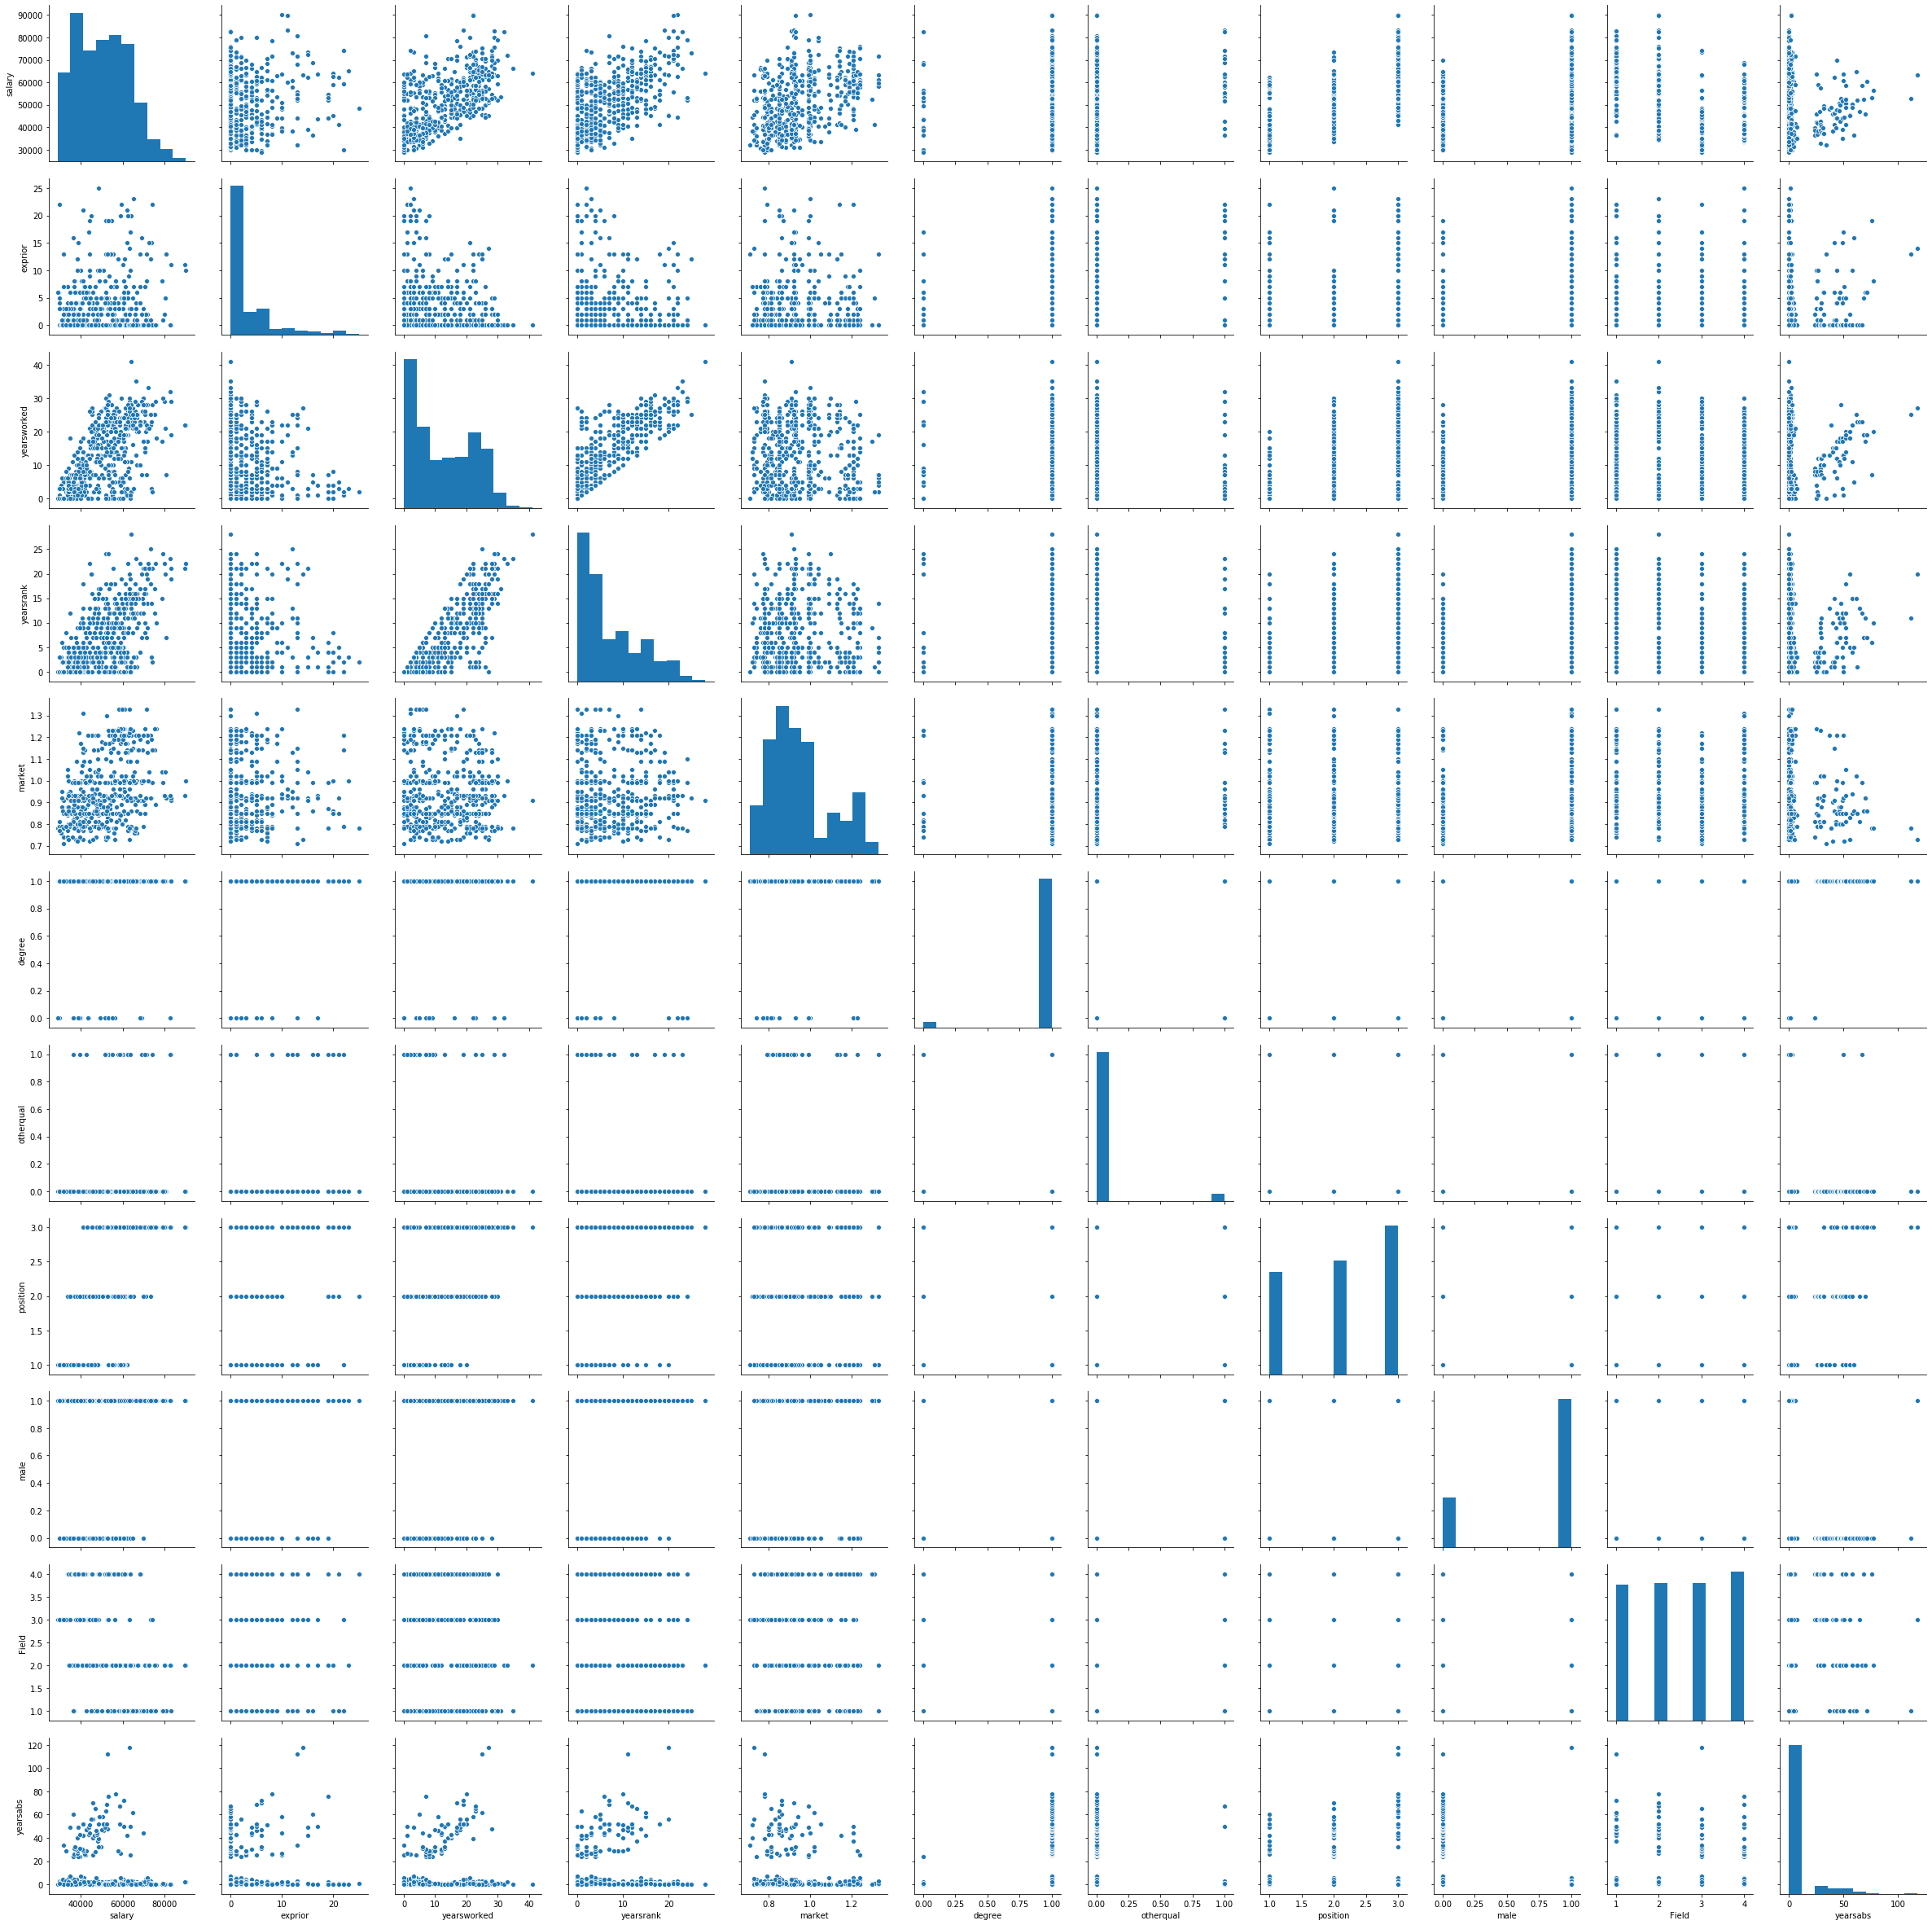

In [9]:
#
_= sns.pairplot(new_salary_data, height =3)

#### -  A descriptive statistics table to further characterise and describe the population under investigation

In [10]:
new_salary_data.corr()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
salary,1.000000,0.102471,0.632135,0.613411,0.397153,0.043012,0.173972,0.704892,0.362302,-0.493484,-0.066496
exprior,0.102471,1.000000,-0.248118,-0.071533,-0.045262,-0.051132,0.269539,0.112165,0.043824,-0.041153,0.135723
yearsworked,0.632135,-0.248118,1.000000,0.813662,-0.074319,0.028088,-0.040123,0.747183,0.278351,-0.259999,0.056364
yearsrank,0.613411,-0.071533,0.813662,1.000000,-0.032917,0.005836,0.007835,0.483265,0.236262,-0.260419,0.037028
market,0.397153,-0.045262,-0.074319,-0.032917,1.000000,0.035405,0.023147,-0.020056,0.178630,-0.217271,-0.165736
degree,0.043012,-0.051132,0.028088,0.005836,0.035405,1.000000,-0.214591,0.042989,0.061227,-0.097773,0.029584
otherqual,0.173972,0.269539,-0.040123,0.007835,0.023147,-0.214591,1.000000,0.161575,0.016332,-0.078059,-0.017945
position,0.704892,0.112165,0.747183,0.483265,-0.020056,0.042989,0.161575,1.000000,0.316646,-0.284845,0.031296
male,0.362302,0.043824,0.278351,0.236262,0.178630,0.061227,0.016332,0.316646,1.000000,-0.126357,-0.621940
Field,-0.493484,-0.041153,-0.259999,-0.260419,-0.217271,-0.097773,-0.078059,-0.284845,-0.126357,1.000000,-0.002017


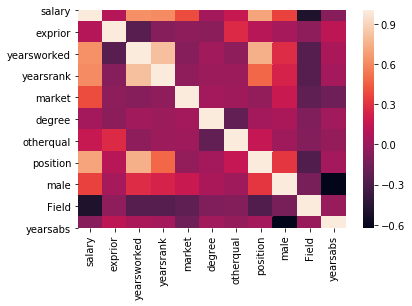

In [11]:
correlation_map = sns.heatmap(new_salary_data.corr())


In [12]:
new_salary_data.describe()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,50695.574473,2.898438,12.833984,7.029297,0.947598,0.964844,0.044922,2.128906,0.750000,2.535156,7.005859
std,12408.394738,4.739128,9.452413,6.416186,0.148936,0.184355,0.207335,0.819876,0.433436,1.125550,16.901868
min,29000.000000,0.000000,0.000000,0.000000,0.710000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,40000.000000,0.000000,4.000000,2.000000,0.840000,1.000000,0.000000,1.000000,0.750000,2.000000,0.000000
50%,50052.000000,0.500000,12.000000,5.000000,0.920000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000
75%,60162.250000,4.000000,22.000000,12.000000,1.020000,1.000000,0.000000,3.000000,1.000000,4.000000,2.000000
max,90082.000000,25.000000,41.000000,28.000000,1.330000,1.000000,1.000000,3.000000,1.000000,4.000000,118.000000


##### variables that seemed to be good predictors of the salary.
By observing the above DataFrame we see a correlation in some of the features which are:
* Position
* Yearsrank
* Yearsworked
* Field

##### variables need to be transformed to be able to use them in a linear regression model.
* Variables that need to be transformed are Field and position because they are catergorical variable. Categorical variables require special attention in regression analysis because, continuous variables, they cannot by entered into the regression equation just as they are.  Instead, they need to be recoded into a series of variables which can then be entered into the regression model.

## 2. Performing some basic features engineering by one-hot encoding the variable Field into three dummy variables, using HR as the reference category.

In [13]:
#creating dummies
field_dummies = pd.get_dummies(new_salary_data['Field']) 
position_dummies = pd.get_dummies(new_salary_data['position'])

#renaming dummies
field_dummies = field_dummies.rename(columns={1: "Engineering",
                                         2: "Finance", 
                                         3: "Human Resources", 
                                         4: "Marketing"})

position_dummies = position_dummies.rename(columns={1: "Junior Employee", 
                                                    2: "Manager", 
                                                    3:"Executive"})

#merging the field dummies with salary
merged_dummies = pd.concat([new_salary_data, position_dummies ,field_dummies] ,axis = 'columns', ignore_index=False)
merged_dummies.reset_index(drop=True, inplace=True)

merged_dummies.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs,Junior Employee,Manager,Executive,Engineering,Finance,Human Resources,Marketing
0,53000.0,0,0,0,1.17,1,0,1,1,3,0,1,0,0,0,0,1,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0,1,0,0,0,1,0,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2,1,0,0,0,0,1,0
3,35782.0,0,2,1,0.99,1,0,1,1,4,1,1,0,0,0,0,0,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1,1,0,0,0,0,0,1


In [14]:
# Dropiing columns not needed
salary_predictors = merged_dummies.drop(["position",
                                       "male",
                                       "Field",
                                       "yearsabs"], axis = 'columns')

salary_predictors.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,Junior Employee,Manager,Executive,Engineering,Finance,Human Resources,Marketing
0,53000.0,0,0,0,1.17,1,0,1,0,0,0,0,1,0
1,58000.0,1,0,0,1.24,1,0,1,0,0,0,1,0,0
2,45500.0,0,0,0,1.21,1,0,1,0,0,0,0,1,0
3,35782.0,0,2,1,0.99,1,0,1,0,0,0,0,0,1
4,34731.0,0,2,2,0.91,1,0,1,0,0,0,0,0,1


## 3. Performing correlation and statistical significance analysis to validate the relationship salary to each of the potential predictor variables:

 
* Pearson correlation coeffificent and plot the correspnding correlation matrix

In [15]:
yearsworked_vs_salary = pearsonr(salary_predictors['yearsworked'] , salary_predictors['salary'])
print('Years worked vs salary = ', yearsworked_vs_salary )

yearsrank_vs_salary = pearsonr(salary_predictors['yearsrank'] , salary_predictors['salary'])
print('Years rank vs salary = ', yearsrank_vs_salary )

junior_employee_vs_salary = pearsonr(salary_predictors['Junior Employee'] , salary_predictors['salary'])
print('Junior employee vs salary = ', junior_employee_vs_salary )

manager_vs_salary = pearsonr(salary_predictors['Manager'] , salary_predictors['salary'])
print('Manager vs salary = ', manager_vs_salary )

executive_vs_salary = pearsonr(salary_predictors['Executive'] , salary_predictors['salary'])
print('Executive vs salary = ', executive_vs_salary )

engineering_vs_salary = pearsonr(salary_predictors['Engineering'] , salary_predictors['salary'])
print('Engineering vs salary = ', engineering_vs_salary )

finance_vs_salary = pearsonr(salary_predictors['Finance'] , salary_predictors['salary'])
print('Finance vs salary = ', finance_vs_salary )

hr_vs_salary = pearsonr(salary_predictors['Human Resources'] , salary_predictors['salary'])
print('HR vs salary = ', hr_vs_salary )

marketing_vs_salary = pearsonr(salary_predictors['Marketing'] , salary_predictors['salary'])
print('Marketing vs salary = ', marketing_vs_salary )

# predictors_pearson_correlation = salary_predictors.corr(method ='pearson')
# display(predictors_pearson_correlation)

Years worked vs salary =  (0.632134532200623, 1.7755624016355923e-58)
Years rank vs salary =  (0.6134113329373261, 3.0361406890501405e-54)
Junior employee vs salary =  (-0.5438520452780111, 9.481432829181748e-41)
Manager vs salary =  (-0.1927809161439487, 1.1192882669944325e-05)
Executive vs salary =  (0.6782437915836459, 2.971476545033544e-70)
Engineering vs salary =  (0.41457174005134145, 1.1002853477338155e-22)
Finance vs salary =  (0.24482591357592948, 2.001579713570849e-08)
HR vs salary =  (-0.43838554319421147, 1.8516352407772795e-25)
Marketing vs salary =  (-0.21335795457045031, 1.1038998304413863e-06)


In [16]:
# getting feature correlation
correlation = salary_predictors.corr().sort_values(by=["salary"], ascending=False)
correlation

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,Junior Employee,Manager,Executive,Engineering,Finance,Human Resources,Marketing
salary,1.000000,0.102471,0.632135,0.613411,0.397153,0.043012,0.173972,-0.543852,-0.192781,0.678244,0.414572,0.244826,-0.438386,-0.213358
Executive,0.678244,0.109303,0.663071,0.440705,0.002459,0.050654,0.165207,-0.517019,-0.559939,1.000000,0.281823,0.115933,-0.308446,-0.085615
yearsworked,0.632135,-0.248118,1.000000,0.813662,-0.074319,0.028088,-0.040123,-0.637682,-0.085870,0.663071,0.215123,0.152177,-0.267499,-0.096198
yearsrank,0.613411,-0.071533,0.813662,1.000000,-0.032917,0.005836,0.007835,-0.399470,-0.080652,0.440705,0.193009,0.172118,-0.240300,-0.120721
Engineering,0.414572,0.044867,0.215123,0.193009,0.189601,0.083158,0.031468,-0.158854,-0.145079,0.281823,1.000000,-0.322988,-0.322988,-0.339993
market,0.397153,-0.045262,-0.074319,-0.032917,1.000000,0.035405,0.023147,0.039309,-0.040657,0.002459,0.189601,0.124726,-0.247986,-0.063700
Finance,0.244826,0.005552,0.152177,0.172118,0.124726,0.035199,0.095005,-0.133322,0.006114,0.115933,-0.322988,1.000000,-0.326425,-0.343611
otherqual,0.173972,0.269539,-0.040123,0.007835,0.023147,-0.214591,1.000000,-0.113993,-0.064844,0.165207,0.031468,0.095005,-0.080126,-0.045034
exprior,0.102471,1.000000,-0.248118,-0.071533,-0.045262,-0.051132,0.269539,-0.085031,-0.033598,0.109303,0.044867,0.005552,-0.037546,-0.012318
degree,0.043012,-0.051132,0.028088,0.005836,0.035405,1.000000,-0.214591,-0.022990,-0.031459,0.050654,0.083158,0.035199,-0.063282,-0.053274


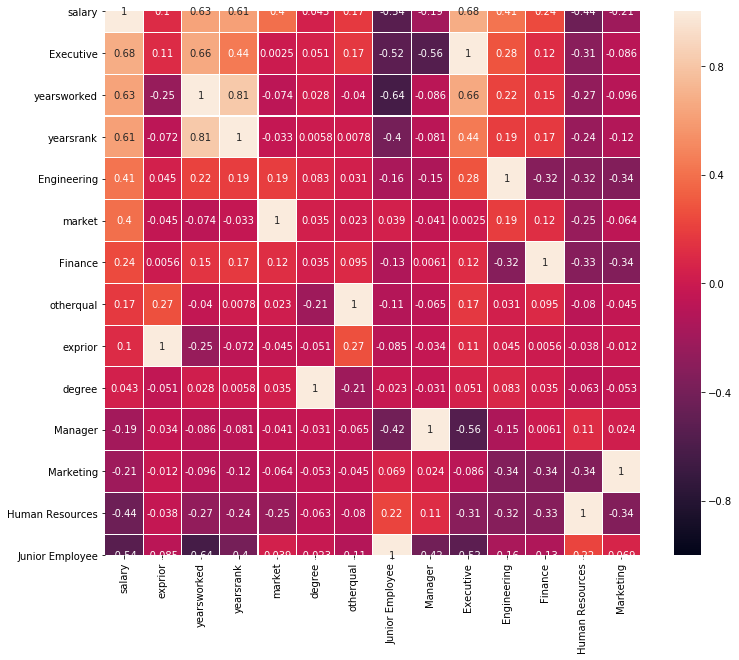

In [17]:
plt.figure(figsize=(12,10))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, linewidth=0.1)

##### Cheking for multicolinearity

In [18]:
vif = pd.DataFrame()
X = salary_predictors[['yearsworked','yearsrank','Engineering','Executive','Human Resources','Junior Employee']] # colums with atleast abs 0.4 correlation with salary
# for each feature(independant variable in X), calculate VIF
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["feature"] = X.columns
# vif = pd.DataFrame()
vif

,VIF,feature
0,11.412345,yearsworked
1,7.181260,yearsrank
2,1.478480,Engineering
3,3.406143,Executive
4,1.407469,Human Resources
5,1.325712,Junior Employee


#####  
* Any problems that may adversely affect the multiple regression (e.g multicollinearity)
The yearsworked has highest vif above 10, which means it will affect the regression, therefore yearsworked should be dropped

## 4. Conducting some basic feature selection tasks by aggreating results from EDA, correlation matrix and p-values.

In [19]:
x = salary_predictors[['yearsrank','Engineering','Executive','Human Resources','Junior Employee']]
y = salary_predictors['salary']
x = sm.add_constant(x)

## 5. Spliting data into a training and test set

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25, random_state=10)


## 6. Train model

In [21]:
model = sm.OLS(y_train,x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     163.8
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           2.76e-92
Time:                        01:52:50   Log-Likelihood:                -3949.2
No. Observations:                 384   AIC:                             7910.
Df Residuals:                     378   BIC:                             7934.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.368e+04    862.129     50.661      0.000     4.2e+04    4.54e+04
yearsrank         621.3929     64.987      9.562      0.000     493.612     749.174
Engineering      4426.3260    936.587      4.726      0.000    2584.753    6267.899
Executive        9657.0910    953.760     10.125      0.000    7781.751    1.15e+04
Human Resources -4075.5391    909.516     -4.481      0.000   -5863.884   -2287.194
Junior Employee -4910.7209    961.844     -5.106      0.000   -6801.956   -3019.486
==============================================================================
Omnibus:                       55.409   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.166
Skew:                           1.002   Prob(JB):                     2.89e-17
Kurtosis:                       3.864   Cond. No.                         34.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* 

In [22]:
lm = LinearRegression()
# fit the model to the training data
results = lm.fit(x_train,y_train)
print('Intercept:',results.intercept_)

Intercept: 43676.41468739954


In [23]:
model.params

const              43676.414687
yearsrank            621.392917
Engineering         4426.326034
Executive           9657.090950
Human Resources    -4075.539128
Junior Employee    -4910.720925
dtype: float64

## 7. Test model:

In [24]:
model_test = sm.OLS(y_test,x_test).fit()
model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     41.82
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           6.66e-25
Time:                        01:52:51   Log-Likelihood:                -1316.7
No. Observations:                 128   AIC:                             2645.
Df Residuals:                     122   BIC:                             2663.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.476e+04   1501.013     29.821      0.000    4.18e+04    4.77e+04
yearsrank         616.6706    118.509      5.204      0.000     382.071     851.270
Engineering      6292.3869   1569.614      4.009      0.000    3185.180    9399.594
Executive        6883.7324   1585.015      4.343      0.000    3746.036       1e+04
Human Resources -6504.6975   1757.626     -3.701      0.000   -9984.093   -3025.302
Junior Employee -3837.8110   1815.604     -2.114      0.037   -7431.981    -243.641
==============================================================================
Omnibus:                        7.920   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.725
Skew:                           0.588   Prob(JB):                       0.0210
Kurtosis:                       3.253   Cond. No.                         34.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 8. Evaluate model

#  
* Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Square Error (RMSE) and R-squared values model

In [25]:
# Rmse of training ad testing
train_rmse = rmse(y_train, model.predict(x_train))
test_rmse = rmse(y_test, model.predict(x_test))
rmse_difference = test_rmse - train_rmse
print("Train model RMSE = ",train_rmse)
print("Test model RMSE = ",test_rmse)
print("difference = ", rmse_difference)

Train model RMSE =  7082.444099040622
Test model RMSE =  7339.493474033066
difference =  257.0493749924444


In [26]:
#Create residuals
residual  = model.resid

#Fit linear model to dataset
results   = model.fittedvalues

#create instance of influence
influence = model.get_influence()

#leverage (hat values)
leverage  = influence.hat_matrix_diag

#Cook's D values (and p-values) as tuple of arrays
cooks_d   = influence.cooks_distance

#standardized residuals
standardized_residuals = influence.resid_studentized_internal

#studentized residuals
studentized_residuals  = influence.resid_studentized_external


#Representing residuals and fitted values in a table

resid_n_fitted = {'Residual': residual, 'Standard_residual':studentized_residuals, 'Predicted Salary': results, 'Actual Salary' :y_train}


resid_n_fitted = pd.DataFrame(resid_n_fitted)

resid_n_fitted.head()


,Residual,Standard_residual,Predicted Salary,Actual Salary
498,-10572.878135,-1.515692,55619.878135,45047.0
26,-4802.479596,-0.676410,40008.479596,35206.0
181,8155.775411,1.154881,58381.224589,66537.0
401,15743.520404,2.230645,40008.479596,55752.0
154,5785.487864,0.816510,38418.512136,44204.0


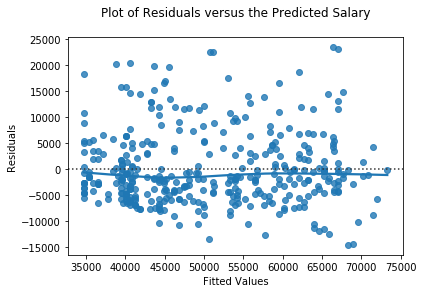

In [27]:
sns.residplot(x = results, y = residual, lowess=True)

plt.title('Plot of Residuals versus the Predicted Salary\n')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals');

## 9. Benchmark with cross-validation model

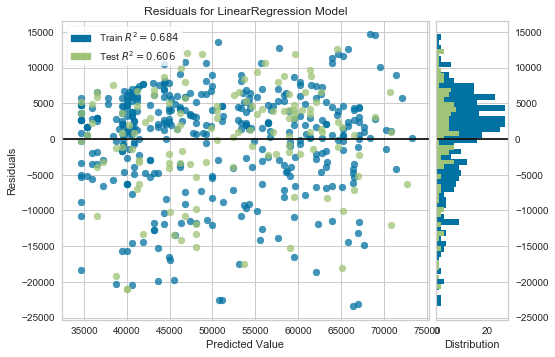

In [28]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show()

**This is a good model with R value of 0.6**

* It has Linear relationship
* It has no auto-correlationz
* It has no multicollinearity
* It has multivariate normality